# Predicting the survival of a passenger

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Loading the dataset
train_dataset = pd.read_csv("../input/train.csv")
test_dataset = pd.read_csv("../input/test.csv")

# putting both the dataframe in one list
containers = [train_dataset,test_dataset]

## The goal will be achieved in three steps
### 1. Cleaning the data
### 2. EDA (Exploratory Data Analysis)
### 3. Making predictions

## We begin with the first step 'Cleaning the data'

In [3]:
containers[0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
containers[1].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# Finding the number of emply cells in training and test data

for container in containers:
    print(container.isnull().sum())
    print("\n\n\n")

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64




PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64






In [6]:
for container in containers:
    print(container.info())
    print("\n\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-n

In [7]:
# Writing functions to create derived columns

def age_group_creation(x):
    if x>=71 and x<=80:
        return '71-80'
    elif x>=61:
        return '61-70'
    elif x>=51:
        return '51-60'
    elif x>=41:
        return '41-50'
    elif x>=31:
        return '31-40'
    elif x>=21:
        return '21-30'
    elif x>=11:
        return '11-20'
    elif x>=0:
        return '0-10'
    else:
        return 'None'

def fare_group_creation(x):
    if x>500 and x<=550:
        return '501-550'
    elif x>=451:
        return '451-500'
    elif x>=401:
        return '401-450'
    elif x>=351:
        return '351-400'
    elif x>=301:
        return '301-350'
    elif x>=251:
        return '251-300'
    elif x>=201:
        return '201-250'
    elif x>=151:
        return '151-200'
    elif x>=101:
        return '101-150'
    elif x>=51:
        return '51-100'
    elif x>=0:
        return '0-50'
    else:
        return 'None'

def title_extractor(x):
    return (x[x.find(',')+1:x.find('.')]).strip()



In [8]:
# Creating derived columns for training and test data

def create_derived(containers):
    for container in containers:
        container['age_cat'] = container['Age'].apply(age_group_creation)
        container['fare_cat'] = container['Fare'].apply(fare_group_creation)
        container['Travel_alone'] = (container['SibSp'] + container['Parch']).apply(lambda x: 0 if x>0 else 1)
        container['title'] = container['Name'].apply(title_extractor)
        container['Ticket_init'] = container['Ticket'].apply(lambda x: x[0])
        
create_derived(containers)
containers[1].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_cat,fare_cat,Travel_alone,title,Ticket_init
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,31-40,0-50,1,Mr,3
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,41-50,0-50,0,Mrs,3
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,61-70,0-50,1,Mr,2
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,21-30,0-50,1,Mr,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,21-30,0-50,0,Mrs,3


#### Taking care of missing data in 'Embarked' column in train_dataset

In [9]:
containers[0]['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
containers[0][containers[0]['Embarked'].isnull() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_cat,fare_cat,Travel_alone,title,Ticket_init
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,31-40,51-100,1,Miss,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,61-70,51-100,1,Mrs,1


In [11]:
containers[0].loc[containers[0]['fare_cat'] == '51-100',:]['Embarked'].value_counts()

S    70
C    32
Q     2
Name: Embarked, dtype: int64

In [12]:
containers[0].loc[containers[0]['Ticket'].apply(lambda x: x.startswith('1135')),:]['Embarked'].value_counts()

S    5
C    2
Name: Embarked, dtype: int64

In [13]:

for container in containers:
    print(container.loc[(container['fare_cat'] == '51-100') & (container['Pclass'] == 1) & (container['Sex'] == 'female') 
                      & (container['Travel_alone'] == 1) & (container['Ticket_init'] == '1'),:]['Embarked'].value_counts())
    print("\n\n\n")

S    6
C    2
Name: Embarked, dtype: int64




C    1
Name: Embarked, dtype: int64






In [14]:
# As we find that frequency of Embarkment 'S' is the most, we filled the emply cell with 'S'

containers[0].loc[containers[0]['Embarked'].isnull(), 'Embarked'] = 'S'

#### Taking care of missing data in 'Age' column in both train_dataset and test_dataset

In [15]:
# Checking if there is a relationship between age and fare

print(pd.crosstab(containers[0]['fare_cat'], containers[0]['age_cat'], margins = True)) # train data
print("\n\n\n")
print(pd.crosstab(containers[1]['fare_cat'], containers[0]['age_cat'], margins = True)) # test data

age_cat   0-10  11-20  21-30  31-40  41-50  51-60  61-70  71-80  None  All
fare_cat                                                                  
0-50        61    100    195    118     60     26     13      4   155  732
101-150      0      5      3      7      4      2      0      0     3   24
151-200      2      0      2      3      1      1      0      0     0    9
201-250      0      2      3      1      3      0      0      0     2   11
251-300      0      2      3      0      0      0      1      0     0    6
501-550      0      0      0      3      0      0      0      0     0    3
51-100       1      7     25     23     16     13      4      0    17  106
All         64    116    231    155     84     42     18      4   177  891




age_cat   0-10  11-20  21-30  31-40  41-50  51-60  61-70  71-80  None  All
fare_cat                                                                  
0-50        26     46     92     55     25     16      7      0    71  338
101-150      0      1

In [16]:
# # Checking if there is a relationship between travling alone and age

print(pd.crosstab(containers[0]['age_cat'], containers[0]['Travel_alone'], margins = True)) # train data
print("\n\n\n")
print(pd.crosstab(containers[1]['age_cat'], containers[0]['Travel_alone'], margins = True)) # test data

Travel_alone    0    1  All
age_cat                    
0-10           63    1   64
11-20          50   66  116
21-30          73  158  231
31-40          64   91  155
41-50          39   45   84
51-60          17   25   42
61-70           4   14   18
71-80           0    4    4
None           44  133  177
All           354  537  891




Travel_alone    0    1  All
age_cat                    
0-10            5   17   22
11-20          28   19   47
21-30          57   74  131
31-40          22   34   56
41-50          16   29   45
51-60          10   11   21
61-70           5    4    9
71-80           0    1    1
None           34   52   86
All           177  241  418


In [17]:
# Checking the relationship between title and age category

print(pd.crosstab(containers[0]['age_cat'], containers[0]['title'], margins = True))
print("\n\n\n")
print(pd.crosstab(containers[1]['age_cat'], containers[0]['title'], margins = True))

print("A clear relationship exists as we see that 'Master' which is used for young male, hold true in our data")

title    Capt  Col  Don  Dr  Jonkheer ...   Ms  Rev  Sir  the Countess  All
age_cat                               ...                                  
0-10        0    0    0   0         0 ...    0    0    0             0   64
11-20       0    0    0   0         0 ...    0    0    0             0  116
21-30       0    0    0   1         0 ...    1    2    0             0  231
31-40       0    0    1   1         1 ...    0    0    0             1  155
41-50       0    0    0   3         0 ...    0    1    1             0   84
51-60       0    2    0   1         0 ...    0    3    0             0   42
61-70       1    0    0   0         0 ...    0    0    0             0   18
71-80       0    0    0   0         0 ...    0    0    0             0    4
None        0    0    0   1         0 ...    0    0    0             0  177
All         1    2    1   7         1 ...    1    6    1             1  891

[10 rows x 18 columns]




title    Don  Dr  Master  Miss  Mme   Mr  Mrs  Rev  All
age_

In [18]:
# Observing the age data with respect to title (train_dataset)
for title in containers[0]['title'].unique():
    print(title+"\n")
    print(containers[0].loc[(containers[0]['title'] == title) & (containers[0]['Age'].notnull()),['Age']].describe())
    print("\n\n\n")


Mr

              Age
count  398.000000
mean    32.368090
std     12.708793
min     11.000000
25%     23.000000
50%     30.000000
75%     39.000000
max     80.000000




Mrs

              Age
count  108.000000
mean    35.898148
std     11.433628
min     14.000000
25%     27.750000
50%     35.000000
75%     44.000000
max     63.000000




Miss

              Age
count  146.000000
mean    21.773973
std     12.990292
min      0.750000
25%     14.125000
50%     21.000000
75%     30.000000
max     63.000000




Master

             Age
count  36.000000
mean    4.574167
std     3.619872
min     0.420000
25%     1.000000
50%     3.500000
75%     8.000000
max    12.000000




Don

        Age
count   1.0
mean   40.0
std     NaN
min    40.0
25%    40.0
50%    40.0
75%    40.0
max    40.0




Rev

             Age
count   6.000000
mean   43.166667
std    13.136463
min    27.000000
25%    31.500000
50%    46.500000
75%    53.250000
max    57.000000




Dr

             Age
count   6.000000
mean 

In [19]:
# Observing the age data with respect to title (test_dataset)
for title in containers[1]['title'].unique():
    print(title+"\n")
    print(containers[1].loc[(containers[1]['title'] == title) & (containers[1]['Age'].notnull()),['Age']].describe())
    print("\n\n\n")

Mr

              Age
count  183.000000
mean    32.000000
std     11.804497
min     14.000000
25%     23.000000
50%     28.500000
75%     40.000000
max     67.000000




Mrs

             Age
count  62.000000
mean   38.903226
std    15.034070
min    16.000000
25%    26.000000
50%    36.500000
75%    49.500000
max    76.000000




Miss

             Age
count  64.000000
mean   21.774844
std    10.457716
min     0.170000
25%    17.750000
50%    22.000000
75%    29.250000
max    45.000000




Master

             Age
count  17.000000
mean    7.406471
std     4.672470
min     0.330000
25%     5.000000
50%     7.000000
75%    11.500000
max    14.500000




Ms

       Age
count  0.0
mean   NaN
std    NaN
min    NaN
25%    NaN
50%    NaN
75%    NaN
max    NaN




Col

             Age
count   2.000000
mean   50.000000
std     4.242641
min    47.000000
25%    48.500000
50%    50.000000
75%    51.500000
max    53.000000




Rev

             Age
count   2.000000
mean   35.500000
std     7.77817

In [20]:
# From above observation it is clear that 'Age' in both train and test data are comparable with respect to age.
# Therefore to fill the missing values, a dictionary is created using train data with median value in each age category

age_impute = {}

for title in containers[0]['title'].unique():
    age_impute[title] = containers[0].loc[(containers[0]['title'] == title) & (containers[0]['Age'].notnull()),['Age']].median()[0]

# Filing the missing age value in both train and test data
for container in containers:
    for title in age_impute.keys():
        container.loc[(container['title'] == title) & (container['Age'].isnull()),['Age']] = age_impute[title]

In [21]:
age_impute

{'Mr': 30.0,
 'Mrs': 35.0,
 'Miss': 21.0,
 'Master': 3.5,
 'Don': 40.0,
 'Rev': 46.5,
 'Dr': 46.5,
 'Mme': 24.0,
 'Ms': 28.0,
 'Major': 48.5,
 'Lady': 48.0,
 'Sir': 49.0,
 'Mlle': 24.0,
 'Col': 58.0,
 'Capt': 70.0,
 'the Countess': 33.0,
 'Jonkheer': 38.0}

#### Taking care of missing fare data in test_dataset

In [22]:
containers[1].loc[containers[1]['Fare'].isnull(),:]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_cat,fare_cat,Travel_alone,title,Ticket_init
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,51-60,None,1,Mr,3


In [23]:

for container in containers:
    print(container.loc[(container['Pclass'] == 3) & (container['title'] == 'Mr') & (container['Sex'] == 'male') & 
                      (container['Embarked'] == 'S') & (container['age_cat'] == '51-60') & (container['Travel_alone'] == 1) &
                       (container['Ticket_init'] == '3'), :]['Fare'])
    print("\n\n\n")

94     7.2500
406    7.7500
631    7.0542
Name: Fare, dtype: float64




152   NaN
Name: Fare, dtype: float64






In [24]:
containers[0].loc[(containers[0]['Pclass'] == 3) & (containers[0]['title'] == 'Mr') & (containers[0]['Sex'] == 'male') & 
                      (containers[0]['Embarked'] == 'S') & (containers[0]['age_cat'] == '51-60') & (containers[0]['Travel_alone'] == 1) &
                       (containers[0]['Ticket_init'] == '3'), :]['Fare'].describe()

count    3.000000
mean     7.351400
std      0.358812
min      7.054200
25%      7.152100
50%      7.250000
75%      7.500000
max      7.750000
Name: Fare, dtype: float64

In [25]:
# Using median value to impute the missing fare data
containers[1].loc[containers[1]['Fare'].isnull(),['Fare']] = containers[0].loc[(containers[0]['Pclass'] == 3) & (containers[0]['title'] == 'Mr') & (containers[0]['Sex'] == 'male') & 
                      (containers[0]['Embarked'] == 'S') & (containers[0]['age_cat'] == '51-60') & (containers[0]['Travel_alone'] == 1) &
                       (containers[0]['Ticket_init'] == '3'), :]['Fare'].median()

#### Taking care of missing Cabin data in train_dataset and test_dataset

In [26]:
# Droping Cabin column as more than 75% of the data in that columns are null

for container in containers:
    container.drop(['Cabin'], axis = 1, inplace = True)

In [27]:
# Finding the number of emply cells in training and test data

for container in containers:
    print(container.isnull().sum() / len(container.index))
    print("\n\n\n")

PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Embarked        0.0
age_cat         0.0
fare_cat        0.0
Travel_alone    0.0
title           0.0
Ticket_init     0.0
dtype: float64




PassengerId     0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Embarked        0.0
age_cat         0.0
fare_cat        0.0
Travel_alone    0.0
title           0.0
Ticket_init     0.0
dtype: float64






In [28]:
# Calling function create_derived() to fill the missing age_cat

create_derived(containers)

#containers[0].info()

In [29]:
# Finding the number of emply cells in training and test data

for container in containers:
    print(container.isnull().sum() / len(container.index))
    print("\n\n\n")

PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Embarked        0.0
age_cat         0.0
fare_cat        0.0
Travel_alone    0.0
title           0.0
Ticket_init     0.0
dtype: float64




PassengerId     0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Embarked        0.0
age_cat         0.0
fare_cat        0.0
Travel_alone    0.0
title           0.0
Ticket_init     0.0
dtype: float64






### Data has been cleaned. Now beginning with EDA.

In [30]:
containers[0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,age_cat,fare_cat,Travel_alone,title,Ticket_init
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,21-30,0-50,0,Mr,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,31-40,51-100,0,Mrs,P
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,21-30,0-50,1,Miss,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,31-40,51-100,0,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,31-40,0-50,1,Mr,3


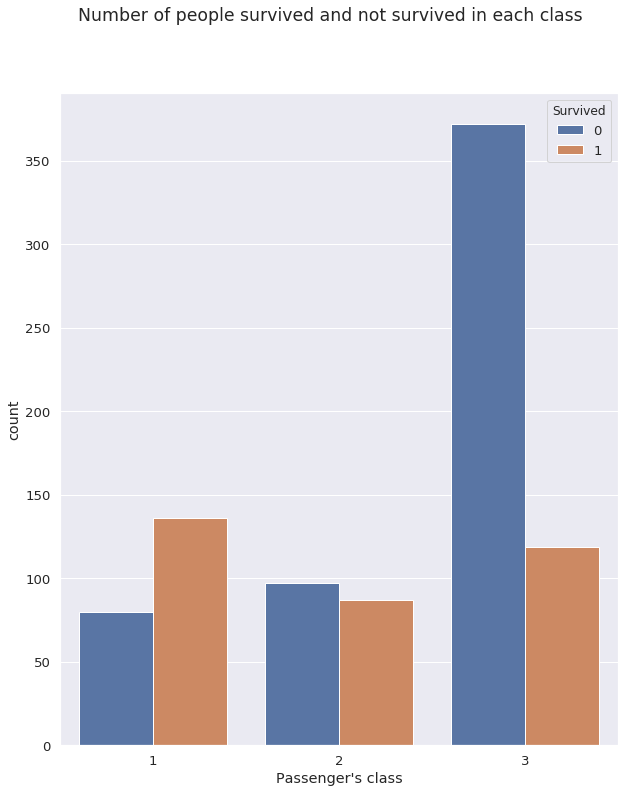

Percentage of people survived from 1st class ticket is 62.96
Percentage of people survived from 2nd class ticket is 47.28
Percentage of people survived from 2nd class ticket is 24.24


We see that 3rd class passengers were very less likely to survive


In [31]:
plt.figure(figsize = (10,12))

sns.set(font_scale = 1.2)
sns.countplot(x = 'Pclass', hue = 'Survived', data = containers[0])
plt.suptitle("Number of people survived and not survived in each class")
plt.xlabel("Passenger's class")

plt.show()

temp = containers[0].groupby(['Pclass'])['Survived'].value_counts()

xper = round((temp[1,1] / temp.loc[[1],[0,1]].sum()) * 100,2)
print("Percentage of people survived from 1st class ticket is "+str(xper))

xper = round((temp[2,1] / temp.loc[[2],[0,1]].sum()) * 100,2)
print("Percentage of people survived from 2nd class ticket is "+str(xper))

xper = round((temp[3,1] / temp.loc[[3],[0,1]].sum()) * 100,2)
print("Percentage of people survived from 2nd class ticket is "+str(xper))

print("\n\nWe see that 3rd class passengers were very less likely to survive")

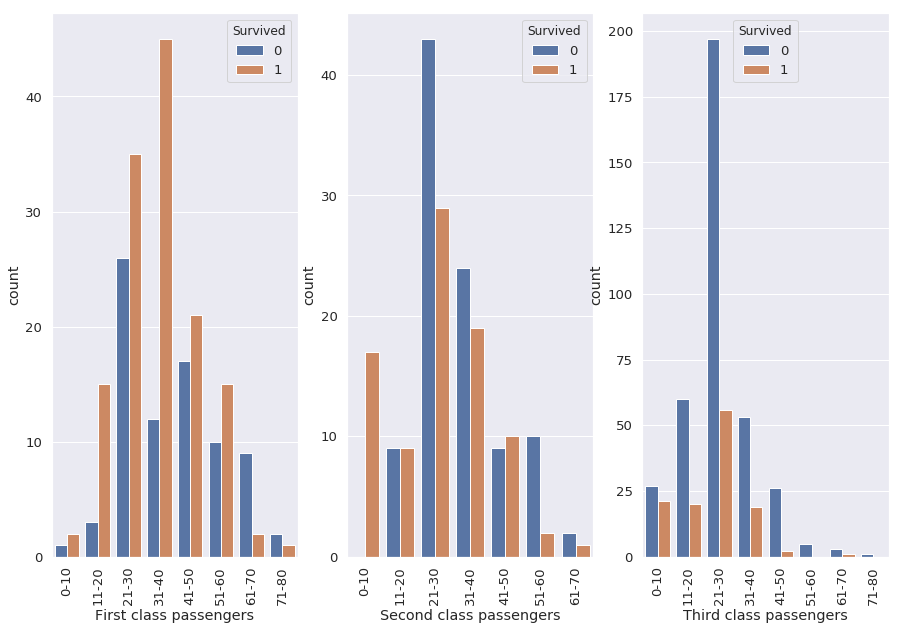

Person with age between 0-10 ,with second class ticket survived the most


In [32]:

plt.figure(figsize = (15,10))

# for 1st class
plt.subplot(1,3,1)

temp = containers[0].loc[containers[0]['Pclass'] == 1,:]
age_cat = containers[0].loc[containers[0]['Pclass'] == 1,:]['age_cat'].unique()
age_cat.sort()

sns.countplot(x = 'age_cat', hue = 'Survived', order = age_cat, data = temp)
plt.xticks(rotation = 90)
plt.xlabel("First class passengers")


# for second class
plt.subplot(1,3,2)

temp = containers[0].loc[containers[0]['Pclass'] == 2,:]
age_cat = containers[0].loc[containers[0]['Pclass'] == 2,:]['age_cat'].unique()
age_cat.sort()

sns.countplot(x = 'age_cat', hue = 'Survived', order = age_cat, data = temp)
plt.xticks(rotation = 90)
plt.xlabel("Second class passengers")


# for third class
plt.subplot(1,3,3)

temp = containers[0].loc[containers[0]['Pclass'] == 3,:]
age_cat = containers[0].loc[containers[0]['Pclass'] == 3,:]['age_cat'].unique()
age_cat.sort()

sns.countplot(x = 'age_cat', hue = 'Survived', order = age_cat, data = temp)
plt.xticks(rotation = 90)
plt.xlabel("Third class passengers")

plt.show()

print("Person with age between 0-10 ,with second class ticket survived the most")

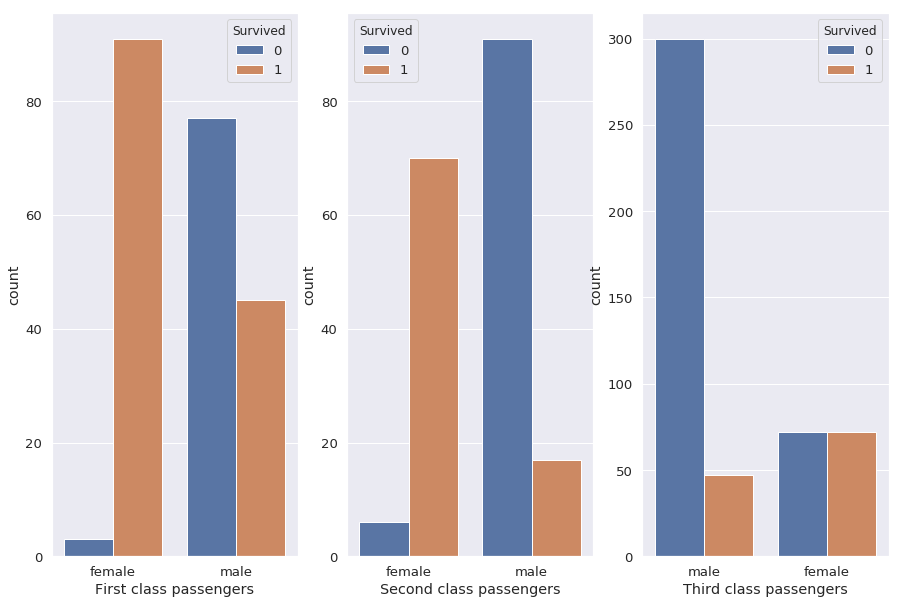

A female person with 1st class ticket survived the most


In [33]:

plt.figure(figsize = (15,10))

# for 1st class
plt.subplot(1,3,1)

temp = containers[0].loc[containers[0]['Pclass'] == 1,:]

sns.countplot(x = 'Sex', hue = 'Survived', data = temp)
plt.xlabel("First class passengers")


# for second class
plt.subplot(1,3,2)

temp = containers[0].loc[containers[0]['Pclass'] == 2,:]

sns.countplot(x = 'Sex', hue = 'Survived', data = temp)
plt.xlabel("Second class passengers")


# for third class
plt.subplot(1,3,3)

temp = containers[0].loc[containers[0]['Pclass'] == 3,:]

sns.countplot(x = 'Sex', hue = 'Survived', data = temp)
plt.xlabel("Third class passengers")

plt.show()

print("A female person with 1st class ticket survived the most")

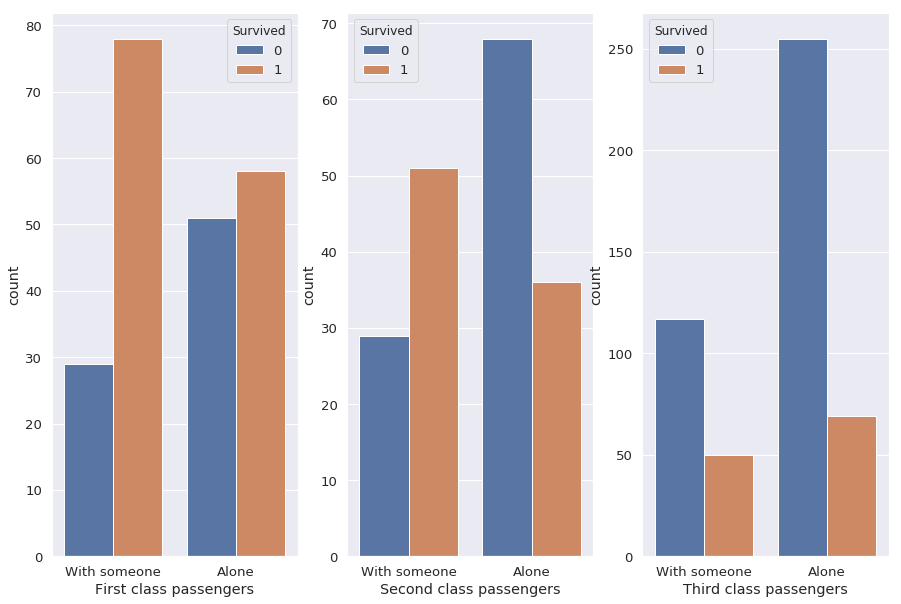

There is a higher chance of surviving if you are with someone


In [34]:
plt.figure(figsize = (15,10))

# for 1st class
plt.subplot(1,3,1)

temp = containers[0].loc[containers[0]['Pclass'] == 1,:]

sns.countplot(x = 'Travel_alone', hue = 'Survived', data = temp)
plt.xticks([0,1],['With someone', 'Alone'])
plt.xlabel("First class passengers")


# for second class
plt.subplot(1,3,2)

temp = containers[0].loc[containers[0]['Pclass'] == 2,:]

sns.countplot(x = 'Travel_alone', hue = 'Survived', data = temp)
plt.xticks([0,1],['With someone', 'Alone'])
plt.xlabel("Second class passengers")


# for third class
plt.subplot(1,3,3)

temp = containers[0].loc[containers[0]['Pclass'] == 3,:]

sns.countplot(x = 'Travel_alone', hue = 'Survived', data = temp)
plt.xticks([0,1],['With someone', 'Alone'])
plt.xlabel("Third class passengers")

plt.show()

print("There is a higher chance of surviving if you are with someone")

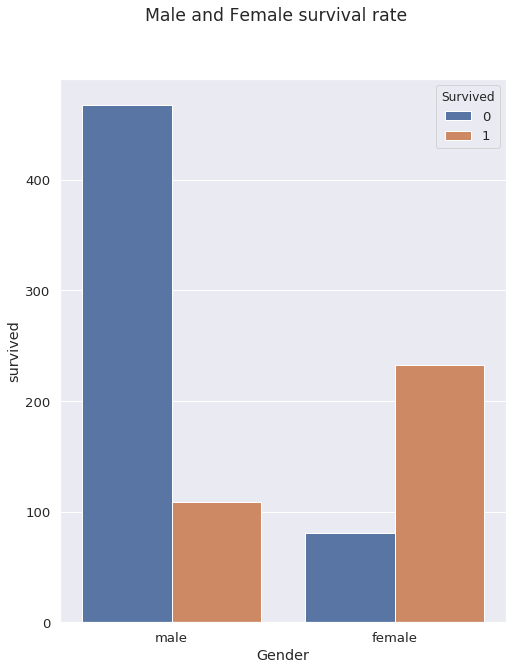

Percentage of male survuved is 18.89
Percentage of femal survuved is 74.2


A female person had a higher chance of survival


In [35]:
# Finding the relationship between survived and other data

temp = pd.crosstab(containers[0]['Survived'], containers[0]['Sex'], margins = True)
x1 = round(((temp['female'][1] / temp['female'][2]) * 100), 2)
x2 = round(((temp['male'][1] / temp['male'][2]) * 100), 2)

plt.figure(figsize = (8,10))

sns.set(font_scale = 1.2)
sns.countplot(x = 'Sex', hue = 'Survived', data = containers[0])
plt.suptitle("Male and Female survival rate")
plt.xlabel("Gender")
plt.ylabel("survived")

plt.show()

print("Percentage of male survuved is "+str(x2))
print("Percentage of femal survuved is "+str(x1))
print("\n\nA female person had a higher chance of survival")

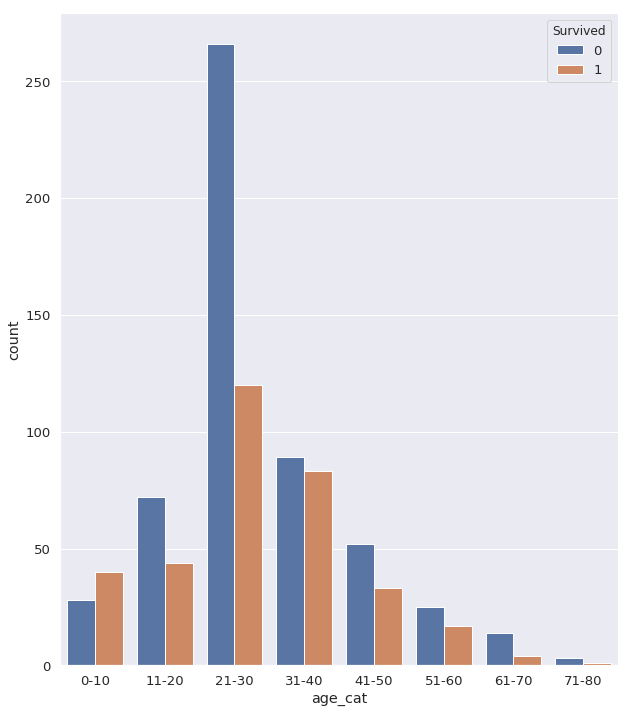

Percentage of people survived in age category 0-10 is 58.82
Percentage of people survived in age category 11-20 is 37.93
Percentage of people survived in age category 21-30 is 31.09
Percentage of people survived in age category 31-40 is 48.26
Percentage of people survived in age category 41-50 is 38.82
Percentage of people survived in age category 51-60 is 40.48
Percentage of people survived in age category 61-70 is 22.22
Percentage of people survived in age category 71-80 is 25.0


Therefore we see that childern between age 0-10 has the highest percentage of being saved

Also person above 60 years of age has less percentage of being saved


In [36]:
plt.figure(figsize = (10,12))

sns.set(font_scale = 1.2)

age_cat = containers[0]['age_cat'].unique()
age_cat.sort()
sns.countplot(x = 'age_cat', hue = 'Survived', order = age_cat, data = containers[0])

plt.show()

temp = pd.crosstab(containers[0]['age_cat'], containers[0]['Survived'], margins = True)
temp

for age in age_cat:
    per_age_cat = round((temp.loc[age,1] / temp.loc[age,'All']) * 100 , 2)
    print("Percentage of people survived in age category "+age+" is "+str(per_age_cat))

print("\n\nTherefore we see that childern between age 0-10 has the highest percentage of being saved")
print("\nAlso person above 60 years of age has less percentage of being saved")

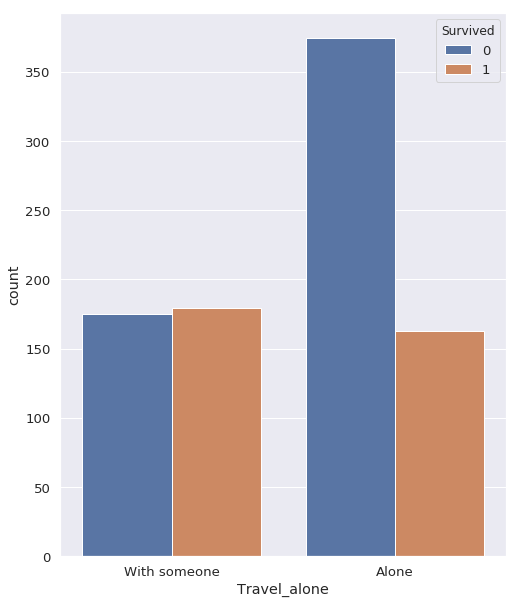

Percentage of people survived who were travelling with someone 50.56
Percentage of people survived who were travelling alone 30.35


Chances of survival are higher if a person is not travelling alone


In [37]:
plt.figure(figsize = (8,10))

sns.set(font_scale = 1.2)
sns.countplot(x = 'Travel_alone', hue = 'Survived', data = containers[0])
plt.xticks([0,1],['With someone', 'Alone'])

plt.show()

temp = pd.crosstab(containers[0]['Travel_alone'], containers[0]['Survived'], margins = True)
x1 = round((temp.loc[0,1] / temp.loc[0,'All']) * 100, 2)
x2 = round((temp.loc[1,1] / temp.loc[1,'All']) * 100, 2)

print("Percentage of people survived who were travelling with someone "+str(x1))
print("Percentage of people survived who were travelling alone "+str(x2))

print("\n\nChances of survival are higher if a person is not travelling alone")

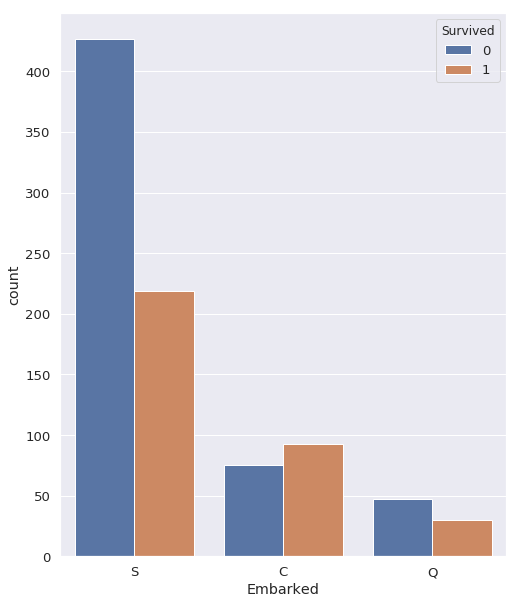

% of people survived, who boarded from Cherbourg is 55.36
% of people survived, who boarded from Southampton is 33.9
% of people survived, who boarded from Queenstown is 38.96


In [38]:
plt.figure(figsize = (8,10))

sns.set(font_scale = 1.2)
sns.countplot(x = 'Embarked', hue = 'Survived', data = containers[0])
#
plt.show()

temp = pd.crosstab(containers[0]['Embarked'], containers[0]['Survived'], margins = True)
x1 = round((temp.loc['C', 1] / temp.loc['C', 'All']) * 100, 2)
x2 = round((temp.loc['S', 1] / temp.loc['S', 'All']) * 100, 2)
x3 = round((temp.loc['Q', 1] / temp.loc['Q', 'All']) * 100, 2)

print("% of people survived, who boarded from Cherbourg is "+str(x1))
print("% of people survived, who boarded from Southampton is "+str(x2))
print("% of people survived, who boarded from Queenstown is "+str(x3))


In [39]:
# We see that women had a better chance of surviving than man.
# People with class 1 ticket had better chance of surviving then the people from other class.
# Childern aged between 0-10 had higher chances of surviving.
# Also second class passengers aged between 0-10 years had higher chances of surviving.
# Ppeople with age between 60-80 years were less likely to survive
# Poeple who boarded from Cherbourg survived more.
# Person is traveling with someone, had igher percentage of surviving members.

In [40]:
temp = containers[0].loc[((containers[0]['Pclass'] == 1) & (containers[0]['Sex'] == 'female')
                   & (containers[0]['Embarked'] == 'C')& (containers[0]['Travel_alone'] == 0)),:]

print(temp['Survived'].value_counts())

print("\n\nTherefore we see that all first class passenger female who boarded from Cherbourg and traveled with someone survived")

1    25
Name: Survived, dtype: int64


Therefore we see that all first class passenger female who boarded from Cherbourg and traveled with someone survived


### Taking care of categorical data

In [41]:
containers[0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,age_cat,fare_cat,Travel_alone,title,Ticket_init
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,21-30,0-50,0,Mr,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,31-40,51-100,0,Mrs,P
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,21-30,0-50,1,Miss,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,31-40,51-100,0,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,31-40,0-50,1,Mr,3


In [42]:
# Converting categorical variables

for container in containers:
    container['Sex'] = container['Sex'].apply(lambda x : 0 if x == 'female' else 1)

# For train data
# Creating a dummy variable for the variable 'Pclass' and dropping the first one.
temp = pd.get_dummies(containers[0]['Pclass'], prefix='Pclass', drop_first=True)
#Adding the results to the master dataframe
containers[0] = pd.concat([containers[0],temp],axis=1)

# Creating a dummy variable for the variable 'Embarked' and dropping the first one.
temp = pd.get_dummies(containers[0]['Embarked'], prefix='Embarked', drop_first=True)
#Adding the results to the master dataframe
containers[0] = pd.concat([containers[0],temp],axis=1)

# Creating a dummy variable for the variable 'title' and dropping the first one.
#temp = pd.get_dummies(containers[0]['title'], prefix='title', drop_first=True)
#Adding the results to the master dataframe
#containers[0] = pd.concat([containers[0],temp],axis=1)

# For test data
# Creating a dummy variable for the variable 'Pclass' and dropping the first one.
temp = pd.get_dummies(containers[1]['Pclass'], prefix='Pclass', drop_first=True)
#Adding the results to the master dataframe
containers[1] = pd.concat([containers[1],temp],axis=1)

# Creating a dummy variable for the variable 'Embarked' and dropping the first one.
temp = pd.get_dummies(containers[1]['Embarked'], prefix='Embarked', drop_first=True)
#Adding the results to the master dataframe
containers[1] = pd.concat([containers[1],temp],axis=1)

# Creating a dummy variable for the variable 'title' and dropping the first one.
#temp = pd.get_dummies(containers[1]['title'], prefix='title', drop_first=True)
#Adding the results to the master dataframe
#containers[1] = pd.concat([containers[1],temp],axis=1)

In [43]:
# Dropping the categorical variables for which dummy varible has been created.
# Also droping few variables which we will not require in prediction.

containers[0].drop(['Pclass','Embarked','title','PassengerId','Name','Ticket','age_cat','fare_cat','Ticket_init'], axis = 1, inplace = True)

containers[1].drop(['Pclass','Embarked','title','Name','Ticket','age_cat','fare_cat','Ticket_init'], axis = 1, inplace = True)

In [44]:
containers[0].head()

,Survived,Sex,Age,SibSp,Parch,Fare,Travel_alone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,0,1,22.0,1,0,7.2500,0,0,1,0,1
1,1,0,38.0,1,0,71.2833,0,0,0,0,0
2,1,0,26.0,0,0,7.9250,1,0,1,0,1
3,1,0,35.0,1,0,53.1000,0,0,0,0,1
4,0,1,35.0,0,0,8.0500,1,0,1,0,1


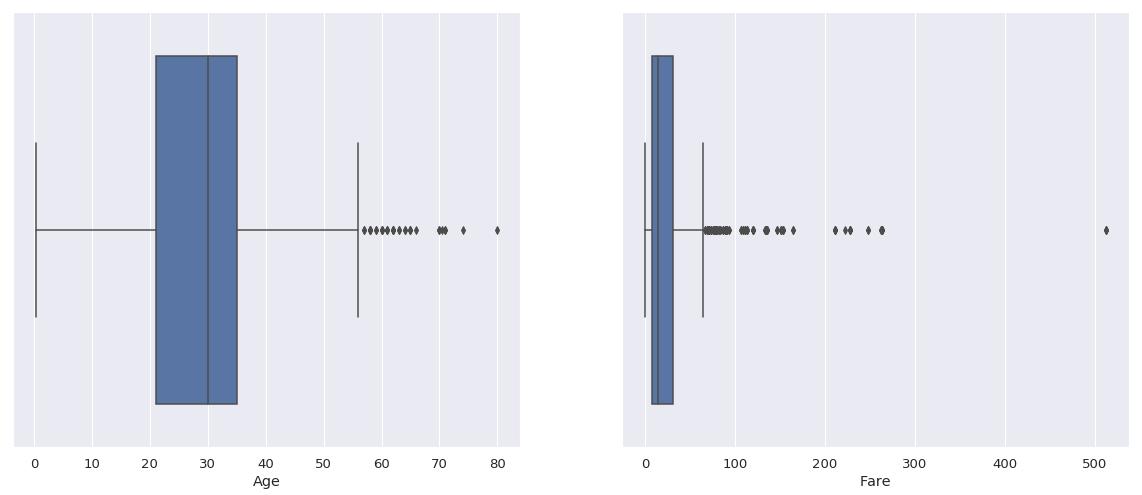

We see both age an fare data has outliers


In [45]:
plt.figure(figsize = (20,8))

sns.set(font_scale = 1.2)

plt.subplot(1,2,1)

sns.boxplot(x = 'Age', data = containers[0])

plt.subplot(1,2,2)

sns.boxplot(x = 'Fare', data = containers[0])

plt.show()

print("We see both age an fare data has outliers")

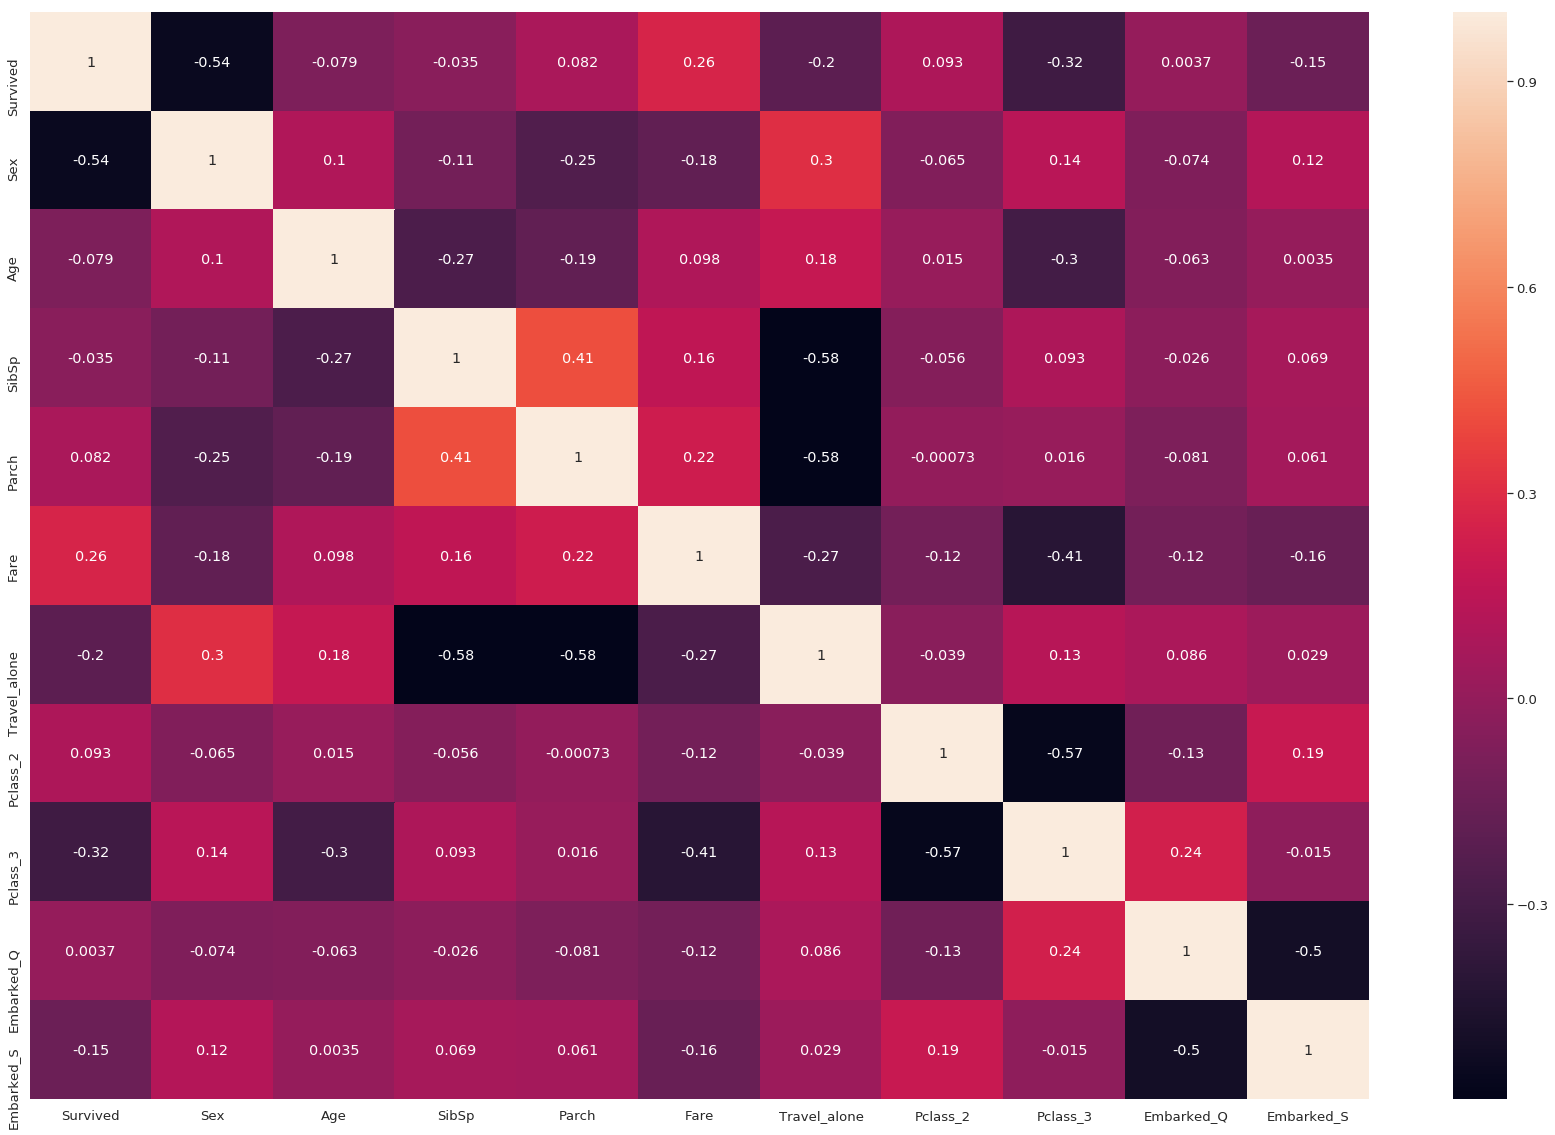

In [46]:
# Making headmap
plt.figure(figsize = (30,20))

corr_mat = containers[0].corr()
sns.heatmap(corr_mat, annot = True)

plt.show()

### Model building

In [47]:
# Feature scaling

containers[0].head()

,Survived,Sex,Age,SibSp,Parch,Fare,Travel_alone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,0,1,22.0,1,0,7.2500,0,0,1,0,1
1,1,0,38.0,1,0,71.2833,0,0,0,0,0
2,1,0,26.0,0,0,7.9250,1,0,1,0,1
3,1,0,35.0,1,0,53.1000,0,0,0,0,1
4,0,1,35.0,0,0,8.0500,1,0,1,0,1


In [48]:
# Feature scaling

# For train data
df = containers[0][['Age','SibSp','Parch','Fare']]
normalized_df=(df-df.mean())/df.std()
containers[0] = containers[0].drop(['Age','SibSp','Parch','Fare'], 1)
containers[0] = pd.concat([containers[0],normalized_df],axis=1)

# For test data
df = containers[1][['Age','SibSp','Parch','Fare']]
normalized_df=(df-df.mean())/df.std()
containers[1] = containers[1].drop(['Age','SibSp','Parch','Fare'], 1)
containers[1] = pd.concat([containers[1],normalized_df],axis=1)

In [49]:
containers[1].head()

,PassengerId,Sex,Travel_alone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Age,SibSp,Parch,Fare
0,892,1,1,0,1,1,0,0.362605,-0.498872,-0.399769,-0.496441
1,893,0,0,0,1,0,1,1.322143,0.616254,-0.399769,-0.511286
2,894,1,1,1,0,1,0,2.473589,-0.498872,-0.399769,-0.463173
3,895,1,1,0,1,0,1,-0.213119,-0.498872,-0.399769,-0.481523
4,896,0,0,0,1,0,1,-0.596934,0.616254,0.619154,-0.416626


In [50]:
# Dividing the data in dependent and independent values

X = containers[0].drop(['Survived'],axis=1)
y = containers[0]['Survived']

In [51]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

#### Buliding first model

In [52]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                            GLM   Df Residuals:                      701
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -303.49
Date:                Tue, 07 May 2019   Deviance:                       606.98
Time:                        06:30:00   Pearson chi2:                     745.
No. Iterations:                     5   Covariance Type:             nonrobust
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.1583      0.382      8.277      0.000       2.410       3.906
Sex             -2.6826      0.231    -11.632      0.000      -3.135      -2.231
Travel_alone    -0.9266      0.314     -2.955      0.003      -1.541      -0.312
Pclass_2        -0.8068      0.330     -2.443      0.015      -1.454      -0.159
Pclass_3        -2.1148      0.336     -6.302      0.000      -2.773      -1.457
Embarked_Q      -0.1487      0.448     -0.332      0.740      -1.027       0.730
Embarked_S      -0.3292      0.273     -1.204      0.229      -0.865       0.207
Age             -0.5810      0.120     -4.855      0.000      -0.816      -0.346
SibSp           -0.5984      0.180     -3.316      0.001      -0.952      -0.245
Parch           -0.2988      0.132     -2.264      0.024      -0.557      -0.040
Fare             0.1214      0.129      0.942      0.346      -0.131       0.374
================================================================================
"""

In [53]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(by = 'VIF', axis=0, ascending=False, inplace=True)

vif

,VIF,features
1,5.037432,Travel_alone
3,4.793852,Pclass_3
5,4.361226,Embarked_S
0,3.076535,Sex
2,2.066922,Pclass_2
7,1.681481,SibSp
8,1.608249,Parch
4,1.510932,Embarked_Q
9,1.320259,Fare
6,1.251076,Age


#### Building second model

In [54]:
# Removing Embarked_Q as it has a very high p-value

X = containers[0].drop(['Survived','Embarked_Q'],axis=1)
y = containers[0]['Survived']

# dividing the data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

In [55]:
# Logistic regression model
logm2 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                            GLM   Df Residuals:                      702
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -303.54
Date:                Tue, 07 May 2019   Deviance:                       607.09
Time:                        06:30:00   Pearson chi2:                     747.
No. Iterations:                     5   Covariance Type:             nonrobust
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.1222      0.365      8.559      0.000       2.407       3.837
Sex             -2.6720      0.228    -11.722      0.000      -3.119      -2.225
Travel_alone    -0.9344      0.313     -2.989      0.003      -1.547      -0.322
Pclass_2        -0.8147      0.329     -2.475      0.013      -1.460      -0.170
Pclass_3        -2.1357      0.330     -6.479      0.000      -2.782      -1.490
Embarked_S      -0.2836      0.237     -1.198      0.231      -0.748       0.180
Age             -0.5813      0.120     -4.861      0.000      -0.816      -0.347
SibSp           -0.6003      0.181     -3.325      0.001      -0.954      -0.246
Parch           -0.2971      0.132     -2.259      0.024      -0.555      -0.039
Fare             0.1239      0.128      0.964      0.335      -0.128       0.376
================================================================================
"""

In [56]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(by = 'VIF', axis=0, ascending=False, inplace=True)

vif

,VIF,features
1,4.881014,Travel_alone
3,4.040245,Pclass_3
4,3.433415,Embarked_S
0,3.075282,Sex
2,1.918859,Pclass_2
6,1.668938,SibSp
7,1.608052,Parch
8,1.310900,Fare
5,1.244901,Age


#### Building 3rd model

In [57]:
# Removing Fare as it has a very high p-value

X = containers[0].drop(['Survived','Embarked_Q','Fare'],axis=1)
y = containers[0]['Survived']

# dividing the data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

In [58]:
# Logistic regression model
logm3 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                            GLM   Df Residuals:                      703
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -304.05
Date:                Tue, 07 May 2019   Deviance:                       608.10
Time:                        06:30:00   Pearson chi2:                     753.
No. Iterations:                     5   Covariance Type:             nonrobust
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.2761      0.332      9.874      0.000       2.626       3.926
Sex             -2.6806      0.227    -11.788      0.000      -3.126      -2.235
Travel_alone    -0.9490      0.311     -3.049      0.002      -1.559      -0.339
Pclass_2        -0.9535      0.297     -3.210      0.001      -1.536      -0.371
Pclass_3        -2.3073      0.280     -8.240      0.000      -2.856      -1.758
Embarked_S      -0.3169      0.234     -1.355      0.176      -0.775       0.142
Age             -0.5891      0.119     -4.938      0.000      -0.823      -0.355
SibSp           -0.5884      0.179     -3.283      0.001      -0.940      -0.237
Parch           -0.2760      0.130     -2.131      0.033      -0.530      -0.022
================================================================================
"""

In [59]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(by = 'VIF', axis=0, ascending=False, inplace=True)

vif

,VIF,features
1,4.723170,Travel_alone
4,3.398415,Embarked_S
3,3.395143,Pclass_3
0,3.049599,Sex
2,1.772270,Pclass_2
6,1.613980,SibSp
7,1.501751,Parch
5,1.244451,Age


#### Building 4th model

In [60]:
# Removing Embarked_S as it has a very high p-value

X = containers[0].drop(['Survived','Embarked_Q','Embarked_S','Fare'],axis=1)
y = containers[0]['Survived']

# dividing the data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

In [61]:
# Logistic regression model
logm4 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                            GLM   Df Residuals:                      704
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -304.96
Date:                Tue, 07 May 2019   Deviance:                       609.93
Time:                        06:30:00   Pearson chi2:                     752.
No. Iterations:                     5   Covariance Type:             nonrobust
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.1288      0.310     10.078      0.000       2.520       3.737
Sex             -2.7097      0.227    -11.962      0.000      -3.154      -2.266
Travel_alone    -0.9977      0.310     -3.221      0.001      -1.605      -0.391
Pclass_2        -1.0422      0.291     -3.585      0.000      -1.612      -0.472
Pclass_3        -2.3368      0.279     -8.373      0.000      -2.884      -1.790
Age             -0.5994      0.119     -5.022      0.000      -0.833      -0.365
SibSp           -0.6259      0.179     -3.493      0.000      -0.977      -0.275
Parch           -0.2892      0.129     -2.237      0.025      -0.543      -0.036
================================================================================
"""

In [62]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(by = 'VIF', axis=0, ascending=False, inplace=True)

vif

,VIF,features
1,4.407037,Travel_alone
3,3.120053,Pclass_3
0,2.860504,Sex
5,1.563439,SibSp
2,1.462554,Pclass_2
6,1.437954,Parch
4,1.230637,Age


#### Building 5th model

In [63]:
# Removing Travel_alone as it has a very high VIF

X = containers[0].drop(['Survived','Embarked_Q','Embarked_S','Fare','Travel_alone'],axis=1)
y = containers[0]['Survived']

# dividing the data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

In [64]:
# Logistic regression model
logm5 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm5.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                            GLM   Df Residuals:                      705
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -310.33
Date:                Tue, 07 May 2019   Deviance:                       620.67
Time:                        06:30:00   Pearson chi2:                     744.
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6892      0.269      9.981      0.000       2.161       3.217
Sex           -2.7946      0.226    -12.362      0.000      -3.238      -2.352
Pclass_2      -1.1135      0.289     -3.847      0.000      -1.681      -0.546
Pclass_3      -2.4745      0.275     -8.996      0.000      -3.014      -1.935
Age           -0.6020      0.117     -5.124      0.000      -0.832      -0.372
SibSp         -0.3359      0.129     -2.612      0.009      -0.588      -0.084
Parch         -0.1083      0.113     -0.963      0.336      -0.329       0.112
==============================================================================
"""

In [65]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(by = 'VIF', axis=0, ascending=False, inplace=True)

vif

,VIF,features
0,2.418448,Sex
2,2.191975,Pclass_3
4,1.267641,SibSp
1,1.264941,Pclass_2
5,1.254802,Parch
3,1.202782,Age


#### Building 6th model

In [66]:
# Removing Parch and zdding Travel_alone as Parch has a very high p-value

X = containers[0].drop(['Survived','Embarked_Q','Embarked_S','Fare','Parch'],axis=1)
y = containers[0]['Survived']

# dividing the data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

In [67]:
# Logistic regression model
logm6 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm6.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                            GLM   Df Residuals:                      705
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -307.62
Date:                Tue, 07 May 2019   Deviance:                       615.24
Time:                        06:30:00   Pearson chi2:                     767.
No. Iterations:                     5   Covariance Type:             nonrobust
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.9279      0.294      9.971      0.000       2.352       3.503
Sex             -2.6501      0.223    -11.875      0.000      -3.087      -2.213
Travel_alone    -0.6881      0.276     -2.497      0.013      -1.228      -0.148
Pclass_2        -1.0594      0.291     -3.646      0.000      -1.629      -0.490
Pclass_3        -2.3628      0.279     -8.466      0.000      -2.910      -1.816
Age             -0.5764      0.117     -4.910      0.000      -0.806      -0.346
SibSp           -0.6256      0.174     -3.605      0.000      -0.966      -0.285
================================================================================
"""

In [68]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(by = 'VIF', axis=0, ascending=False, inplace=True)

vif

,VIF,features
1,3.845714,Travel_alone
3,2.890827,Pclass_3
0,2.860466,Sex
5,1.520577,SibSp
2,1.395302,Pclass_2
4,1.230527,Age


#### Building 7th model

In [69]:
# Removing Travel_alone as it has a very high VIF

X = containers[0].drop(['Survived','Embarked_Q','Embarked_S','Fare','Parch','Travel_alone'],axis=1)
y = containers[0]['Survived']

# dividing the data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

In [70]:
# Logistic regression model
logm7 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm7.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                            GLM   Df Residuals:                      706
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -310.81
Date:                Tue, 07 May 2019   Deviance:                       621.62
Time:                        06:30:00   Pearson chi2:                     753.
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6583      0.267      9.959      0.000       2.135       3.182
Sex           -2.7548      0.221    -12.453      0.000      -3.188      -2.321
Pclass_2      -1.1114      0.289     -3.840      0.000      -1.679      -0.544
Pclass_3      -2.4668      0.275     -8.966      0.000      -3.006      -1.928
Age           -0.5901      0.116     -5.073      0.000      -0.818      -0.362
SibSp         -0.3779      0.122     -3.094      0.002      -0.617      -0.138
==============================================================================
"""

In [71]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(by = 'VIF', axis=0, ascending=False, inplace=True)

vif

,VIF,features
0,2.350501,Sex
2,2.171102,Pclass_3
1,1.253325,Pclass_2
3,1.200022,Age
4,1.083247,SibSp


#### Making model for testing purpose using 7th model

In [72]:
# Making model using 7th model columns

col = ['Sex', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp']
logsk = LogisticRegression()
logsk.fit(X_train[col], y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Predicting Values

In [73]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_test[col])

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Survive_Prob'})

# Let's see the head of y_pred_final
y_pred_final.head()

,Survived,Survive_Prob
0,0,0.798178
1,1,0.670680
2,1,0.107483
3,1,0.687852
4,0,0.214821


In [74]:
# Let's see the head
y_pred_final.head()

,Survived,Survive_Prob
0,0,0.798178
1,1,0.670680
2,1,0.107483
3,1,0.687852
4,0,0.214821


### Checking accuracy

In [75]:
from sklearn import metrics

In [76]:
# Checking with different cut-off percentage to imporve accuracy

num = [float(x)/10 for x in range(10)]
for i in num:
    y_pred_final[i] = y_pred_final['Survive_Prob'].map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,Survived,Survive_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.798178,1,1,1,1,1,1,1,1,0,0
1,1,0.670680,1,1,1,1,1,1,1,0,0,0
2,1,0.107483,1,1,0,0,0,0,0,0,0,0
3,1,0.687852,1,1,1,1,1,1,1,0,0,0
4,0,0.214821,1,1,1,0,0,0,0,0,0,0


In [77]:
# Checking different accuracy for different cut-off predicted values

cutoff_df = pd.DataFrame(columns = ['Cutoff_prob', 'Accuracy', 'Sensitivity', 'Specificity'])
num = [float(x)/10 for x in range(10)]
for i in num:
    conff_mat = metrics.confusion_matrix(y_pred_final['Survived'], y_pred_final[i])
    tot = sum(sum(conff_mat))
    accur = (conff_mat[0,0] + conff_mat[1,1])/tot
    sensi = conff_mat[0,0] / (conff_mat[0,0] + conff_mat[0,1]) # TP/(TP+FN)
    speci = conff_mat[1,1] / (conff_mat[1,1] + conff_mat[1,0]) # TN/(TN + FP)
    cutoff_df.loc[i] = [i, accur, sensi, speci]
    
cutoff_df

,Cutoff_prob,Accuracy,Sensitivity,Specificity
0.0,0.0,0.418994,0.000000,1.000000
0.1,0.1,0.603352,0.355769,0.946667
0.2,0.2,0.692737,0.615385,0.800000
0.3,0.3,0.787709,0.778846,0.800000
0.4,0.4,0.821229,0.836538,0.800000
0.5,0.5,0.804469,0.875000,0.706667
0.6,0.6,0.793296,0.913462,0.626667
0.7,0.7,0.765363,0.980769,0.466667
0.8,0.8,0.731844,1.000000,0.360000
0.9,0.9,0.642458,1.000000,0.146667


In [78]:
# From the above table it is clear that cutoff probability of 0.4 will give high accuracy.
# Therefore using that and predicting

# Creating new column 'predicted' with 1 if Churn_Prob>0.4 else 0
y_pred_final['predicted'] = y_pred_final.Survive_Prob.map( lambda x: 1 if x > 0.4 else 0)

# Let's see the head
y_pred_final.head()

,Survived,Survive_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,predicted
0,0,0.798178,1,1,1,1,1,1,1,1,0,0,1
1,1,0.670680,1,1,1,1,1,1,1,0,0,0,1
2,1,0.107483,1,1,0,0,0,0,0,0,0,0,0
3,1,0.687852,1,1,1,1,1,1,1,0,0,0,1
4,0,0.214821,1,1,1,0,0,0,0,0,0,0,0


In [79]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.Survived, y_pred_final.predicted )
confusion

array([[87, 17],
       [15, 60]])

In [80]:
# Predicted     not_Survived    Survived
# Actual
# not_Survived        87           17
# Survived            15           60  

#Let's check the overall accuracy.
metrics.accuracy_score( y_pred_final.Survived, y_pred_final.predicted)

0.8212290502793296

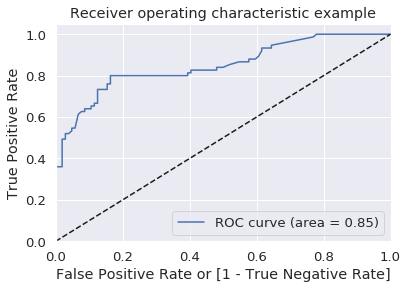

In [81]:
# ROC curve


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_final['Survive_Prob'])
roc_auc = metrics.auc( fpr, tpr )
plt.figure(figsize=(6, 4))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

    

In [82]:
TP = confusion[0,0] # True Positive
TN = confusion[1,1] # True Negative
FP = confusion[0,1] # False Positive
FN = confusion[1,0] # False Negative

In [83]:
# Sencitivity
sensitivity = TP / (TP + FN) # percentage of people correctly identified as survived (True positive rate)
specificity = TN / (TN + FP) # percentage of people correctly identified as not survived
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1score = (2 * precision * recall) / (precision + recall)

print("Sensitivity : "+str(sensitivity))
print("Specificity : "+str(specificity))
print("Precision : "+str(precision))
print("Recall : "+str(recall))
print("f1 score : "+str(f1score))

Sensitivity : 0.8529411764705882
Specificity : 0.7792207792207793
Precision : 0.8365384615384616
Recall : 0.8529411764705882
f1 score : 0.8446601941747574


In [84]:
# Applying K-fold cross validation 

# Creating folds object
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# instanciating a model
model = LogisticRegression()

# Computing cross Validation score
cv_results = cross_val_score(model, X_train, y_train, cv = folds, scoring = 'accuracy')

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [85]:
print(cv_results)
print(cv_results.mean())

[0.7972028  0.76923077 0.79577465 0.82394366 0.82394366]
0.8020191076529105


### Making final model

In [86]:
# Building final model

col = ['Sex', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp']

# Dividing the data in dependent and independent values

X_train = containers[0].drop(['Survived'],axis=1)
y_train = containers[0]['Survived']

X_test = containers[1]

logsk = LogisticRegression()
logsk.fit(X_train[col], y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [87]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_test[col])

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Converting index to dataframe
y_id = pd.DataFrame(X_test['PassengerId'])

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_id.reset_index(drop=True, inplace=True)

# Appending y_id and y_pred_1
y_pred_final = pd.concat([y_id,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Survive_Prob'})

# Let's see the head of y_pred_final
y_pred_final.head()

,PassengerId,Survive_Prob
0,892,0.090856
1,893,0.334937
2,894,0.097690
3,895,0.118219
4,896,0.572846


In [88]:
# Predicting with 0.4, 0.5, 0.6, 0.7, 0.8 as cut-off

num = [0.4, 0.5, 0.6, 0.7, 0.8]

for i in num:
    y_pred_final[i] = y_pred_final['Survive_Prob'].map(lambda x: 1 if x>i else 0)
    
y_pred_final.head()

,PassengerId,Survive_Prob,0.4,0.5,0.6,0.7,0.8
0,892,0.090856,0,0,0,0,0
1,893,0.334937,0,0,0,0,0
2,894,0.097690,0,0,0,0,0
3,895,0.118219,0,0,0,0,0
4,896,0.572846,1,1,0,0,0


In [89]:
# Here 0.6 was used as it was giving the maximum accuracy
d = pd.DataFrame({'PassengerId': y_pred_final['PassengerId'], 'Survived': y_pred_final[0.6]})
d.set_index('PassengerId', inplace = True)
d.to_csv('predictions.csv', sep=",")